# Stock Predictor
LSTM architecture to predict Stockprices based on [this Kaggle Dataset](https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs)


In [1]:
%matplotlib inline
from IPython.display import display, clear_output
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
torch.manual_seed(1)

In [41]:
csv = pd.read_csv('./googl.us.txt')
csv.drop(columns=["OpenInt", "Date"], inplace=True)
data = torch.tensor(csv.values, dtype=torch.float)
data = data[:200]
print(data.size()[0])

200


In [35]:
class StockPredictor(nn.Module):
    def __init__(self, layers):
        super(StockPredictor, self).__init__()
        self.layers = layers
        self.lstm = nn.LSTM(5, 1, 1)
        self.lstms = [nn.LSTM(10, 10) for _ in range(layers-1)]
        self.lstms.insert(0, nn.LSTM(5, 10, 1))
        self.final = nn.LSTM(10, 1)
        self.activation = nn.LeakyReLU()
    def forward(self, stock, keep_hidden_state=False):
        if not keep_hidden_state:
            self.hidden = [(torch.randn(1, 1, 10),
                       torch.randn(1, 1, 10))for _ in range(self.layers)] + [(torch.randn(1, 1, 1),
                       torch.randn(1, 1, 1))]
        out = 0
        for i, lstm in enumerate(self.lstms):
            if i != 0:
                out, self.hidden[i] = lstm(out, self.hidden[i])
            else:
                out, self.hidden[i] = lstm(stock, self.hidden[i])
            #out = self.activation(out)
        out, self.hidden[self.layers] = self.final(out, self.hidden[self.layers])
        return out

In [36]:
model = StockPredictor(1)
optim = torch.optim.RMSprop(model.parameters(), lr=0.1)
loss_function = nn.MSELoss()

In [34]:
#load ignore if you want a new model
model.load_state_dict(torch.load("./model.sav"))
model.eval()

RuntimeError: Error(s) in loading state_dict for StockPredictor:
	Missing key(s) in state_dict: "final.weight_ih_l0", "final.weight_hh_l0", "final.bias_ih_l0", "final.bias_hh_l0". 
	Unexpected key(s) in state_dict: "final.weight", "final.bias". 

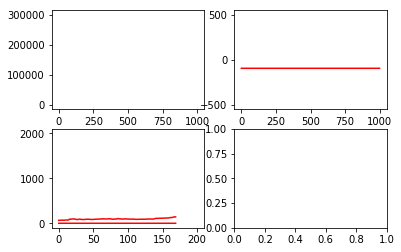

999: 94.78502655029297 | 84440840.0


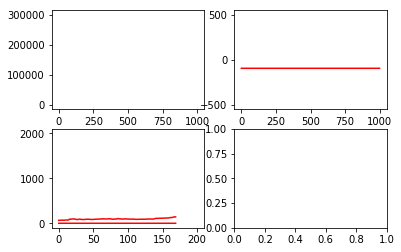

In [44]:
test_seperate = 3000
epochs = 1000
losses = []
deltas = []
fig, ((lax, dax), (cmpax, _)) = plt.subplots(ncols=2, nrows=2)
lplot, = lax.plot([0, epochs], [300000, 0], 'b')
dplot, = dax.plot([0, epochs], [500, -500], 'r')
rplot, = cmpax.plot([0, data.size()[0]], [0, 2000], 'r')
pplot, = cmpax.plot([0, data.size()[0]], [0, 2000], 'r')
for epoch in range(epochs):
    model.zero_grad()
    inputs = data[:-30, :].view(-1, 1, 5) #inferring length of the sequence
    target = data[30:, 3]
    prediction = model.forward(inputs)
    loss = loss_function(prediction[:, 0].view(-1), target)**2
    loss.backward()
    optim.step()
    delta = prediction - data[30:, 3]
    # visualising learning progress
    deltas.append(np.asscalar(delta.mean().detach().numpy()))
    losses.append(np.asscalar(loss.detach().numpy()))
    lplot.set_data(range(epoch+1), losses)
    dplot.set_data(range(epoch+1), deltas)
    rplot.set_data(range(data.size()[0]-30), target.detach().numpy())
    pplot.set_data(range(data.size()[0]-30), prediction.detach().numpy())
    clear_output(wait=True)
    display(fig)
    print(f'\r{epoch}: {delta.abs().mean()} | {loss}')
    
    
plt.show()    
    

In [23]:
#saving
torch.save(model.state_dict(), "./model.sav")